In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import msprime

import matplotlib.patches as patches
import matplotlib.path as mpath
from matplotlib.collections import PatchCollection

from pylab import rcParams
from IPython.core.display import display, HTML

In [2]:
%matplotlib inline
sns.set_style('white')
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
paper_palette_names = ["baby pink", "brick", "yellow orange", "grass green", "blue", "purple"]
paper_palette = sns.xkcd_palette(paper_palette_names)
col_of_rel = collections.OrderedDict(zip(['UN', 'DR', 'C1', 'HS', 'FS', 'PO'], paper_palette_names))
#col_of_rel

In [4]:
k_of_rel = {
'PO': (0, 1, 0),
'FS': (.25, .5, .25), 
'HS': (.5, .5, 0),
'C1': (.75, .25, 0),
'DR': (0.9375,  0.0625, 0 ),
'UN': (1, 0,  0)
}

In [5]:
def exp_R0_from_derivation(f, k):
    """given a frequency (f) and a realtionship producing the k vector (k1, k1, k2), 
    return the expected R0 value"""
    assert len(k) == 3
    assert (f < 1).all()
    assert (f > 0).all()
        
    k0, k1, k2 = k
    num = 2 * k0 * f * (1-f)
    denom = k0 * 4 * f * (1-f) + k1 + 2*k2
    return(num/denom)

def exp_R1_from_derivation(f, k):
    """given a frequency (f) and a relationship producing the k vector (k1, k1, k2), 
    return the expected R1 value"""
    assert len(k) == 3
    assert (f < 1).all()
    assert (f > 0).all()
    k0, k1, k2 = k
    num = k0 * 4 * f * (1-f) + k1 + 2*k2
    denom = k0 * (4 - 6 * f * (1-f)) + 2*k1 
    return(num/denom)



In [6]:
def make_2d_SFS_related(genotype_matrix, k, remove_nonsegregating = True):
    """
    Make the genotypes for a pairr of related individuals given 4 unrelated haplotypes.
    This function takes an (X,4) haploid gentoype matrix and a vector of k0, k1, k2 values.  
    It samples a random IBD state at each site and then constructs a pair genotypes that 
    relects the IBD status at that site.  
    It returns an 2Dsfs, that counts the genotypes of each type A-I, 
    optionally removing the nonsegregating types A & I.
    """
    
    k0, k1, k2 = k
    assert sum(k) == 1
    pair_twoDsfs = np.zeros((3,3))
    hap1, hap2, hap3, hap4 = genotype_matrix.T
    ind1 = hap1+hap2
    IBD = np.random.choice([0,1,2], size = len(hap1), p = k)
    where_IBD0 = hap3+hap4
    where_IBD1 = hap3+hap1
    where_IBD2 = hap1+hap2 
    ind2 = np.where(IBD == 2, where_IBD2, (np.where(IBD==1, where_IBD1, where_IBD0)))
    for x,y in zip(ind1, ind2):
        pair_twoDsfs[x,y]+=1
    if remove_nonsegregating:
        pair_twoDsfs[0,0]=0
        pair_twoDsfs[2,2]=0
    return(pair_twoDsfs) 

In [7]:
# these functions take a 2dSFS (3x3) and return the relevant statistic (R0, R1, or KING-robust kinship)

def count_sfs(twoDsfs):
    return (twoDsfs.T.flatten())

def R0_sfs(twoDsfs):
    A, B, C, D, E, F, G, H, I = count_sfs(twoDsfs)
    num = C+G
    denom = E
    return(np.float(num)/denom)

def R1_sfs(twoDsfs):
    A, B, C, D, E, F, G, H, I = count_sfs(twoDsfs)
    num = E 
    denom = B+C+D+F+G+H
    return(np.float(num)/denom)

def Kin_sfs(twoDsfs):
    A, B, C, D, E, F, G, H, I = count_sfs(twoDsfs)
    num = E - 2*(C+G)
    denom = B+D+F+H+E+E
    return(np.float(num)/denom)

In [8]:
def find_gr(N_current, N_ancestral, T):
    """find the growth rate given current size, past size and generations ago"""
    ratio = np.float(N_ancestral) / N_current
    gr = -1.0 * np.log(ratio) /100.0
    return(gr)

In [44]:
LEN = 1e8
#LEN = 1e6
SEED = 10101
scale = 10
# The Ne does not affect the ratios between the values B,C,D, E, F, G, H, only how many non-segregating sites (A,I) there are relative to the rest

scenarios = {
    'neutral':msprime.simulate(sample_size=4, Ne=1000, mutation_rate=1e-8, length = LEN, num_replicates=1000*scale, recombination_rate=1e-8, random_seed=SEED),
    
    'growth_10000now_1000anc_100gen':msprime.simulate(length = LEN,random_seed=SEED,
                    recombination_rate = 1e-8,
                    mutation_rate=1e-8,
                    population_configurations = [msprime.PopulationConfiguration(sample_size=4, initial_size=10000, growth_rate = find_gr(N_current=10000, N_ancestral=1000, T=100))],
                    demographic_events=[msprime.PopulationParametersChange(time=100, initial_size=1000, growth_rate=0, population_id=0)],
                    num_replicates = 500*scale),
    
    'shrink_1000now_10000anc_100gen':msprime.simulate(length = LEN,random_seed=SEED,
                    recombination_rate = 1e-8,
                    mutation_rate=1e-8,
                    population_configurations =  [msprime.PopulationConfiguration(sample_size=4, initial_size=1000, growth_rate = find_gr(N_current=1000, N_ancestral=10000, T=100))],
                    demographic_events=[msprime.PopulationParametersChange(time=100, initial_size=10000, growth_rate=0, population_id=0)],
                    num_replicates = 100*scale)
    
}
scenarios

{'growth_10000now_1000anc_100gen': <generator object _replicate_generator at 0x7f6b907b3730>,
 'neutral': <generator object _replicate_generator at 0x7f6b90687690>,
 'shrink_1000now_10000anc_100gen': <generator object _replicate_generator at 0x7f6b83a21b40>}

In [45]:
# dealing with the genotype matrices is the slow part

In [46]:
gt_of_scenario = dict()
for scenario in scenarios:
    gt_of_scenario[scenario] = np.vstack([ts.genotype_matrix() for ts in scenarios[scenario]])

In [47]:
# add the ascertainment scenario, simulate 40 extra haplotypes
ascertain = msprime.simulate(sample_size=4+40, Ne=1000, mutation_rate=1e-8, length = LEN, random_seed=SEED, num_replicates=1000*scale, recombination_rate=1e-8)
preascertain_gt = np.vstack([ts.genotype_matrix() for ts in ascertain])
# keep only the sites with and an allele count >=2 in the 40 extra haplotypes, then discard the extras
postascertain_gt = preascertain_gt[preascertain_gt[:,4:].sum(1) >=2, :4]
gt_of_scenario['ascertained'] = postascertain_gt

In [48]:
preascertain_gt.shape, postascertain_gt.shape

((173957268, 44), (130199645, 4))

In [49]:
res = []
for scenario, gt in gt_of_scenario.iteritems():
        for rel in k_of_rel:
            twoDsfs = make_2d_SFS_related(gt, k_of_rel[rel], remove_nonsegregating = True)
            R1 = R1_sfs(twoDsfs)
            R0 = R0_sfs(twoDsfs)
            Kin = Kin_sfs(twoDsfs)
            nsites = np.sum(twoDsfs).astype(int)
            A, B, C, D, E, F, G, H, I = count_sfs(twoDsfs).astype(int)
            res.append((scenario, rel, R1, R0, Kin, nsites, A, B, C, D, E, F, G, H, I))
            res_df = pd.DataFrame(res)

In [50]:
res_df.columns = ['scenario', 'rel', 'R1', 'R0', 'Kin', 'nsites',  'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
res_df        

,scenario,rel,R1,R0,Kin,nsites,A,B,C,D,E,F,G,H,I
0,growth_10000now_1000anc_100gen,FS,0.660635,0.069771,0.249848,30056843,0,6133088,416863,6130012,11957231,2502351,417408,2499890,0
1,growth_10000now_1000anc_100gen,HS,0.327193,0.196926,0.124738,34372810,0,8780864,834031,8777886,8473926,3335980,834704,3335419,0
2,growth_10000now_1000anc_100gen,UN,0.213444,0.501551,-0.000502,37849552,0,10595531,1668580,10587940,6657704,3332223,1670600,3336974,0
3,growth_10000now_1000anc_100gen,C1,0.265069,0.330920,0.062143,36113082,0,9689028,1250189,9683387,7566742,3335500,1253797,3334439,0
4,growth_10000now_1000anc_100gen,DR,0.225568,0.454693,0.015157,37415863,0,10367419,1564741,10361878,6886454,3332554,1566481,3336336,0
5,growth_10000now_1000anc_100gen,PO,0.499592,0.000000,0.249898,30899061,0,6965171,0,6969341,10294081,3339511,0,3330957,0
6,neutral,FS,0.667676,0.071136,0.250315,58319490,0,11676366,828703,11641655,23348971,4986738,832241,5004816,0
7,neutral,HS,0.333924,0.199212,0.125447,66645951,0,16675480,1660282,16640204,16683638,6652019,1663293,6671035,0
8,neutral,UN,0.222590,0.497722,0.000760,73317162,0,20007743,3319485,19980226,13348442,6662970,3324328,6673968,0
9,neutral,C1,0.273133,0.331806,0.063119,69982553,0,18341493,2489637,18313691,15013766,6657054,2492018,6674894,0


In [51]:
# patches for the expected ranges 
rel_patches = []
path_of_rel = dict()
for rel in col_of_rel:
    if rel != 'DR':
        xx = exp_R1_from_derivation(f = np.arange(.00001, .5, .00001), k = k_of_rel[rel])
        yy = exp_R0_from_derivation(f = np.arange(.00001, .5, .00001), k = k_of_rel[rel])
        Path = mpath.Path
        cords = zip(xx, yy)
        path_data = [(Path.MOVETO, cords[0])] + [(Path.LINETO, [x_cord, y_cord]) for (x_cord, y_cord) in cords[1:-1]] + [(Path.CLOSEPOLY, cords[-1])]
        codes, verts = zip(*path_data)
        path = mpath.Path(verts, codes)
        path_of_rel[rel] = path
        patch = patches.PathPatch(path, edgecolor = sns.xkcd_rgb[col_of_rel[rel]], linewidth = 3, facecolor = sns.xkcd_rgb[col_of_rel[rel]], alpha = .3)
        rel_patches.append(patch)

In [52]:
marker_of_scenario = dict()
marker_of_scenario['neutral'] = 'o'
marker_of_scenario['growth_10000now_1000anc_100gen'] = '^'
marker_of_scenario['shrink_1000now_10000anc_100gen'] = 'v'
marker_of_scenario['ascertained'] = '*'

In [53]:
KING_kinship_expectation_of_rel = collections.OrderedDict([
    ('MZ', 1./(2**1)),
    ('PO', 1./(2**2)), 
    ('FS', 1./(2**2)),
    ('HS', 1./(2**3)),
    ('C1', 1./(2**4)), 
    ('C2', 1./(2**5)),
    ('UN', 0)
]
)

# Plot

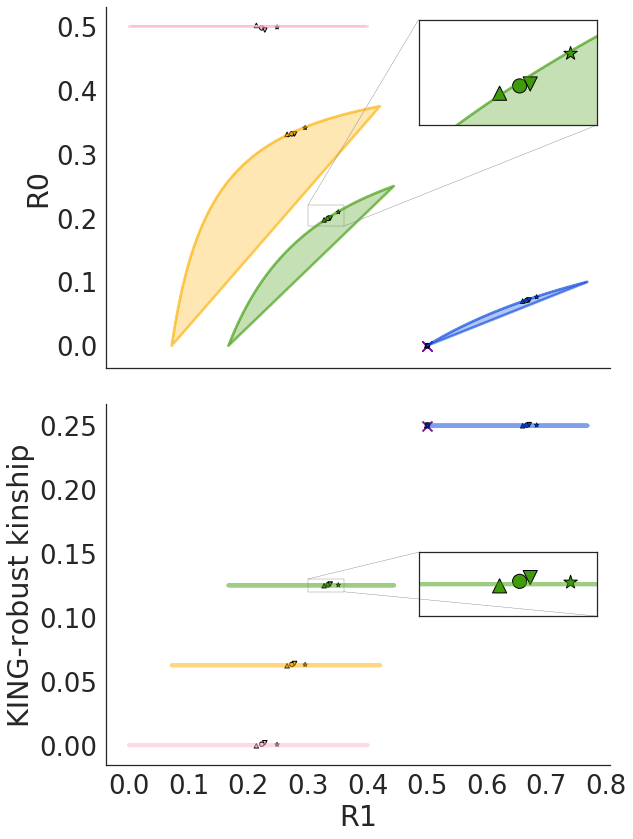

In [54]:
with sns.plotting_context('talk', font_scale = 2):
    fig, ax = plt.subplots(ncols = 1, nrows=2, figsize = (10,13), sharex = True)
    atop = ax[0]
    abot = ax[1]
    for rel in k_of_rel:
        if rel is not 'DR':
            atop.plot(exp_R1_from_derivation(f = np.arange(.00001, 1, .00001), k = k_of_rel[rel]), 
                                 exp_R0_from_derivation(f = np.arange(.00001, 1, .00001), k = k_of_rel[rel]), 
                                 label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], lw = 2, alpha = .5)
            R1_means = []
            R0_means = []
            for xxx in range(1, 100):
                R1_means.append(np.mean(exp_R1_from_derivation(f = np.repeat([.00001, .5], [xxx, 100-xxx]) , k = k_of_rel[rel])) )
                R0_means.append(np.mean(exp_R0_from_derivation(f = np.repeat([.00001, .5], [xxx, 100-xxx]) , k = k_of_rel[rel])) )
            atop.plot(R1_means, R0_means, label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], lw = 2, alpha = .5)

            if rel == 'PO':
                atop.scatter(exp_R1_from_derivation(f = np.arange(.001, 1, .001), k = k_of_rel[rel]), 
                     exp_R0_from_derivation(f = np.arange(.001, 1, .001), k = k_of_rel[rel]), marker = 'x',
                     label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], s = 100, alpha = .2, lw = .2)

    collection = PatchCollection(rel_patches, match_original=True)
    atop.add_collection(collection)
    for scenario in marker_of_scenario:
        toplot = res_df.query('(scenario == @scenario) & (rel != "DR")')
        atop.scatter(toplot['R1'], toplot['R0'], 
                #label = '_nolegend_', 
                c = [sns.xkcd_rgb[col_of_rel[rel]] for rel in toplot['rel']], 
                marker = marker_of_scenario[scenario],
                s = 20, alpha = 1, lw = 1, edgecolors = 'k', linewidths = 1)

    # add the inset
    import mpl_toolkits.axes_grid.inset_locator
    azoom =  mpl_toolkits.axes_grid.inset_locator.zoomed_inset_axes(atop, zoom=5, loc ='upper right'
                                                                    
                                                                )
    for rel in ['HS']:
        azoom.plot(exp_R1_from_derivation(f = np.arange(.00001, 1, .00001), k = k_of_rel[rel]), 
                             exp_R0_from_derivation(f = np.arange(.00001, 1, .00001), k = k_of_rel[rel]), 
                             label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], lw = 2, alpha = .5)
        R1_means = []
        R0_means = []
        for xxx in range(1, 100):
            R1_means.append(np.mean(exp_R1_from_derivation(f = np.repeat([.00001, .5], [xxx, 100-xxx]) , k = k_of_rel[rel])) )
            R0_means.append(np.mean(exp_R0_from_derivation(f = np.repeat([.00001, .5], [xxx, 100-xxx]) , k = k_of_rel[rel])) )
        azoom.plot(R1_means, R0_means, label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], lw = 2, alpha = .5)

    collection = PatchCollection(rel_patches, match_original=True)
    azoom.add_collection(collection)
    for scenario in marker_of_scenario:
        toplot = res_df.query('(scenario == @scenario) & (rel != "DR")')
        azoom.scatter(toplot['R1'], toplot['R0'], 
                #label = '_nolegend_', 
                c = [sns.xkcd_rgb[col_of_rel[rel]] for rel in toplot['rel']], 
                marker = marker_of_scenario[scenario],
                s = 200, alpha = 1, lw = 1, edgecolors = 'k', linewidths = 1)
    azoom.set_ylim(0.187,0.22)
    azoom.set_xlim(0.3,0.36)
    azoom.set_xticks([])
    azoom.set_yticks([])
    mpl_toolkits.axes_grid1.inset_locator.mark_inset(atop, azoom, loc1=2, loc2=4, fc="none", ec="0.5")
    sns.despine(ax=atop)
    plt.subplots_adjust(left=.2)

    # bottom
    for rel in ['UN', 'C1', 'HS', 'FS', 'PO']:
        abot.plot(exp_R1_from_derivation(f = np.arange(.00001, 1, .00001), k = k_of_rel[rel]), 
                 [KING_kinship_expectation_of_rel[rel] for xx in np.arange(.00001, 1, .00001)], 
                 label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], lw = 4, alpha = .5)
        if rel == 'PO':
            abot.scatter(exp_R1_from_derivation(f = np.array([.3]), k = k_of_rel[rel]), 
                 KING_kinship_expectation_of_rel[rel], marker = 'x',
                 label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], s = 100, alpha = 1, lw = 2)
    for scenario in marker_of_scenario:
        toplot = res_df.query('(scenario == @scenario) & (rel != "DR")')
        abot.scatter(toplot['R1'], toplot['Kin'], 
                #label = '_nolegend_', 
                c = [sns.xkcd_rgb[col_of_rel[rel]] for rel in toplot['rel']], 
                marker = marker_of_scenario[scenario],
                s = 20, alpha = 1, lw = 1, edgecolors = 'k', linewidths = 1)

    azoom =  mpl_toolkits.axes_grid1.inset_locator.zoomed_inset_axes(abot, zoom=5, loc ='right')
    for rel in ['HS']:
        azoom.plot(exp_R1_from_derivation(f = np.arange(.00001, 1, .00001), k = k_of_rel[rel]), 
                 [KING_kinship_expectation_of_rel[rel] for xx in np.arange(.00001, 1, .00001)], 
                 label = '_nolegend_', c = sns.xkcd_rgb[col_of_rel[rel]], lw = 4, alpha = .5)
    for scenario in marker_of_scenario:
            toplot = res_df.query('(scenario == @scenario) & (rel != "DR")')
            azoom.scatter(toplot['R1'], toplot['Kin'], 
                    #label = '_nolegend_', 
                    c = [sns.xkcd_rgb[col_of_rel[rel]] for rel in toplot['rel']], 
                    marker = marker_of_scenario[scenario],
                    s = 200, alpha = 1, lw = 1, edgecolors = 'k', linewidths = 1)
    
    azoom.set_ylim(0.12,0.13)
    azoom.set_xlim(0.3,0.36)
    azoom.set_xticks([])
    azoom.set_yticks([])
    atop.set_ylabel('R0')
    abot.set_ylabel('KING-robust kinship')
    abot.set_xlabel('R1')
    mpl_toolkits.axes_grid1.inset_locator.mark_inset(abot, azoom, loc1=2, loc2=4, fc="none", ec="0.5")
    sns.despine(ax=abot)
    plt.subplots_adjust(left=.2, hspace=0.1, bottom = .07)
    fig.savefig('./paper/figures/rev/supplemental_figure_S1_combined.pdf', dpi = 400)
    fig.savefig('./paper/figures/rev/supplemental_figure_S1_combined.png', dpi = 400)